In [31]:
# Precipitation - inches (accumulation)  
# Temperature - Fahrenheit  
# Streamflow - ft³/s

In [32]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [33]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="When grouping with a length-1 list-like, you will need to pass a length-1 tuple"
)

In [34]:
import pandas as pd

df_x = pd.read_csv('data/streamflow_prediction_dataset.csv').iloc[:, [0,7,8,9,10]]
df_x['date'] = pd.to_datetime(df_x['date'])
df_x['PRCP'] = df_x['PRCP_BisonLake'] + df_x['PRCP_McClurePass']
df_x['TAVG'] = (df_x['TAVG_BisonLake'] + df_x['TAVG_McClurePass']) / 2
df_x['PREC_year'] = df_x.groupby(df_x['date'].dt.year)['PRCP'].cumsum()
df_x['PREC_week'] = df_x.groupby(df_x['date'].dt.isocalendar().week)['PRCP'].transform('sum')
df_x['PREC_month'] = df_x.groupby(df_x['date'].dt.month)['PRCP'].transform('sum')
df_x = df_x[['date', 'TAVG', 'PRCP', 'PREC_year', 'PREC_week', 'PREC_month']]

df_y = pd.read_csv('data/streamflow_prediction_dataset.csv')[['date', 'streamflow']]
df_y['date'] = pd.to_datetime(df_y['date'])

# Merge feature and target data
df = pd.merge(df_x, df_y, on='date')

# Set the date as index, fill missing dates, and resample to weekly frequency
df = df.set_index('date').asfreq('D')
# df = df.resample('W').mean()

# Recalculate day of year (DOY) and year
df['DOY'] = df.index.to_series().dt.dayofyear
df['year'] = df.index.year

# Reorder columns for clarity
df = df[['year', 'DOY', 'TAVG', 'PRCP', 'PREC_year', 
         'PREC_week', 'PREC_month', 'streamflow']]

# Display and optionally save the processed DataFrame
display(df)
# df.to_csv('data/streamflow_pred_test.csv', index=False)

,year,DOY,TAVG,PRCP,PREC_year,PREC_week,PREC_month,streamflow
date,,,,,,,,
2008-03-12,2008,72,24.80,0.1,0.1,8.7,45.3,2360.0
2008-03-13,2008,73,NaN,NaN,NaN,NaN,NaN,NaN
2008-03-14,2008,74,NaN,NaN,NaN,NaN,NaN,NaN
2008-03-15,2008,75,17.55,0.3,0.4,8.7,45.3,2260.0
2008-03-16,2008,76,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-07-23,2021,204,57.50,0.4,33.2,10.5,44.7,1170.0
2021-07-24,2021,205,55.85,0.4,33.6,10.5,44.7,1240.0
2021-07-25,2021,206,55.15,0.5,34.1,10.5,44.7,1190.0


In [35]:
print(df.isnull().sum() / len(df))
df = df.dropna()
print(df.isnull().sum() / len(df))

year          0.000000
DOY           0.000000
TAVG          0.386819
PRCP          0.386819
PREC_year     0.386819
PREC_week     0.386819
PREC_month    0.386819
streamflow    0.386819
dtype: float64
year          0.0
DOY           0.0
TAVG          0.0
PRCP          0.0
PREC_year     0.0
PREC_week     0.0
PREC_month    0.0
streamflow    0.0
dtype: float64


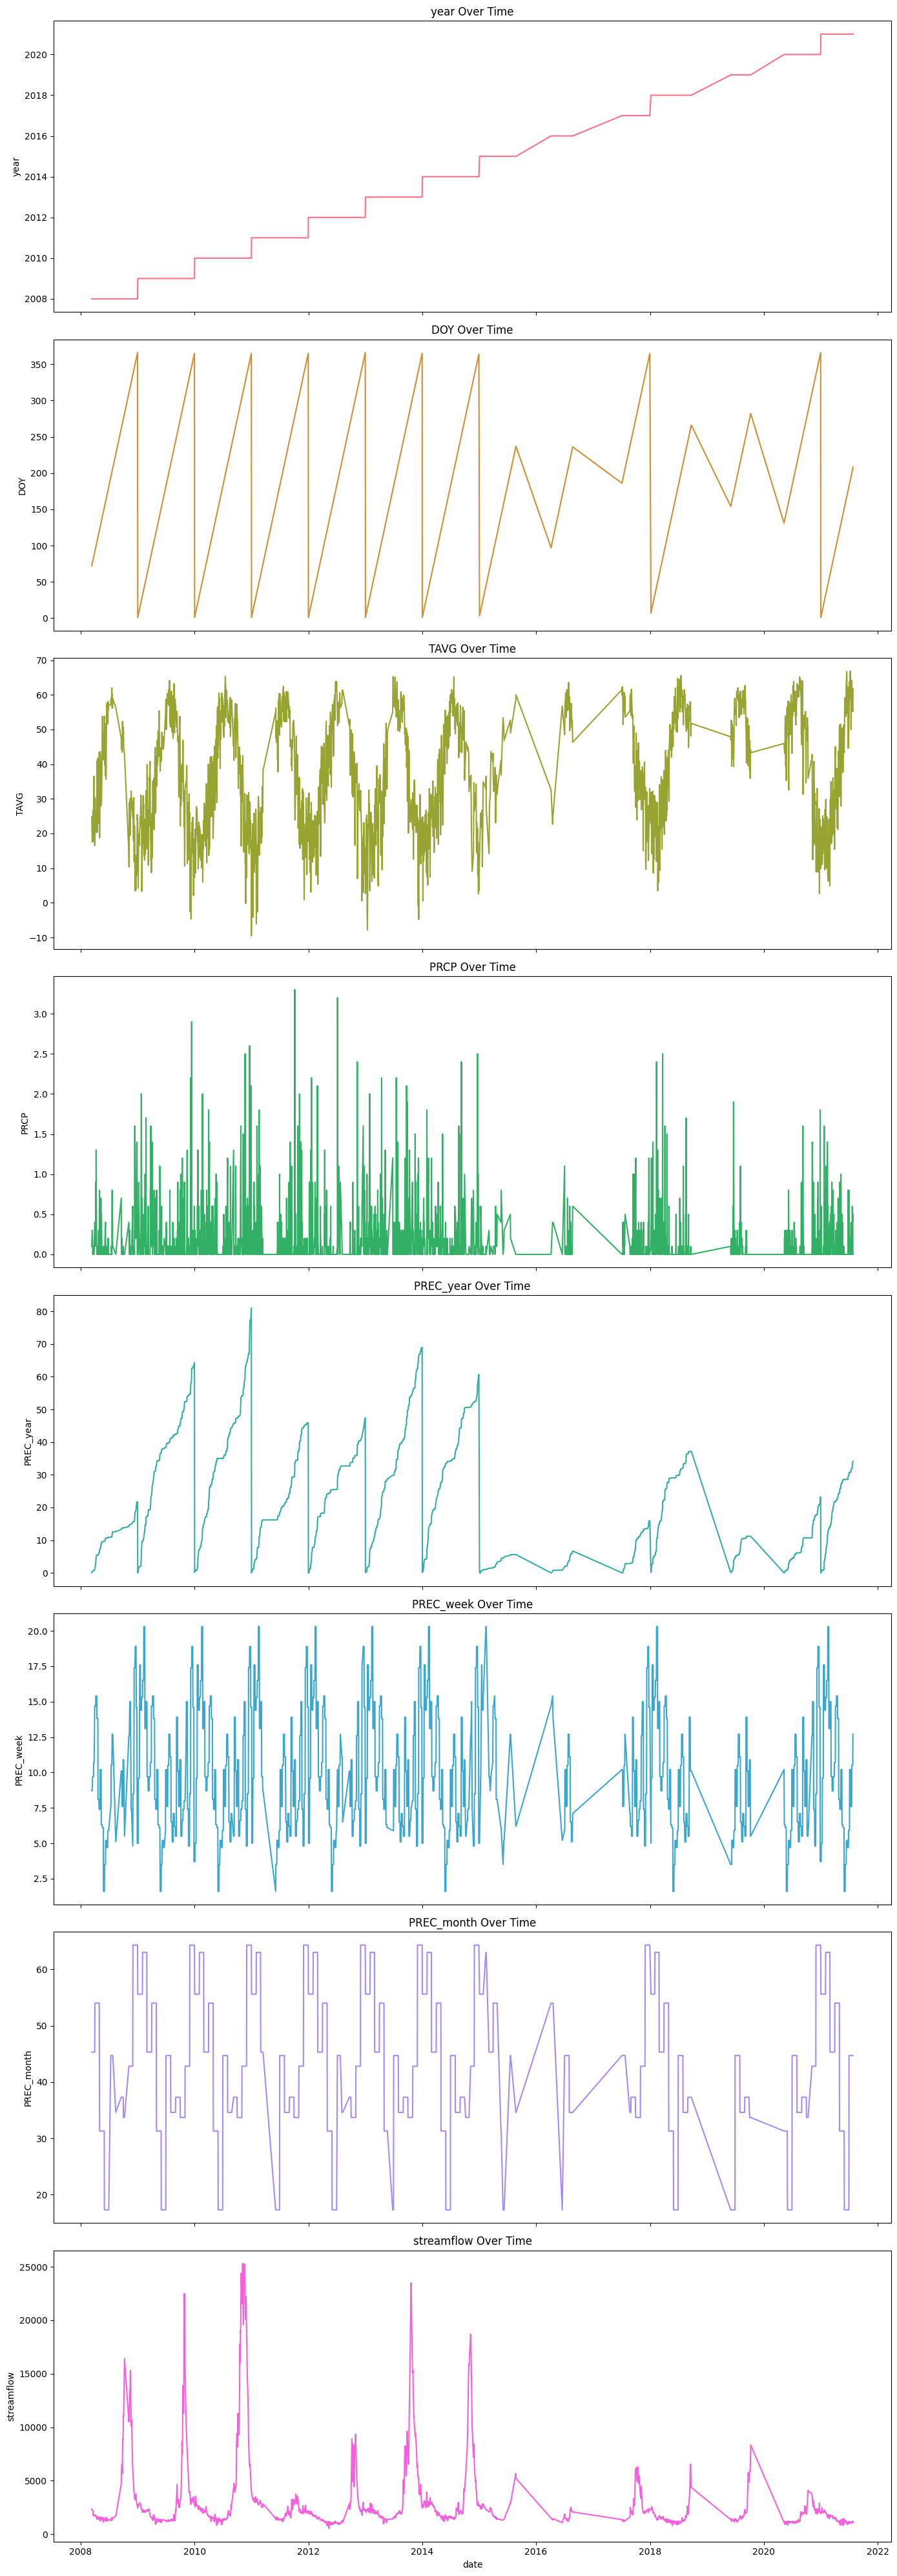

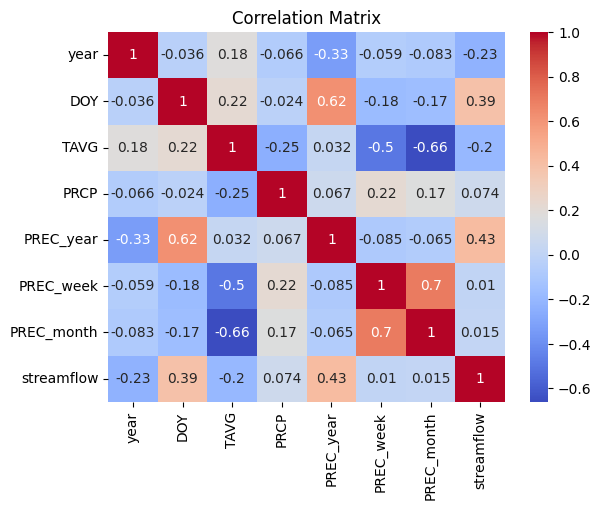

In [36]:
def plot_data(df):
    # Drop rows with NaN values for cleaner plotting
    df_cleaned = df.dropna()
    
    # Number of subplots needed
    num_columns = len(df_cleaned.columns)
    
    # Create subplots
    fig, axs = plt.subplots(num_columns, 1, figsize=(14, 5 * num_columns), sharex=True)
    
    # Ensure axs is iterable (even if there's only one subplot)
    if num_columns == 1:
        axs = [axs]
    
    # Generate colors for the plots
    colors = sns.color_palette("husl", num_columns)
    
    # Plot each column
    for i, column in enumerate(df_cleaned.columns):
        sns.lineplot(data=df_cleaned, x=df_cleaned.index, y=column, ax=axs[i], color=colors[i])
        axs[i].set_ylabel(column)
        axs[i].set_title(f'{column} Over Time')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    
    # Plot the correlation matrix
    corr = df_cleaned.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()
    
plot_data(df)

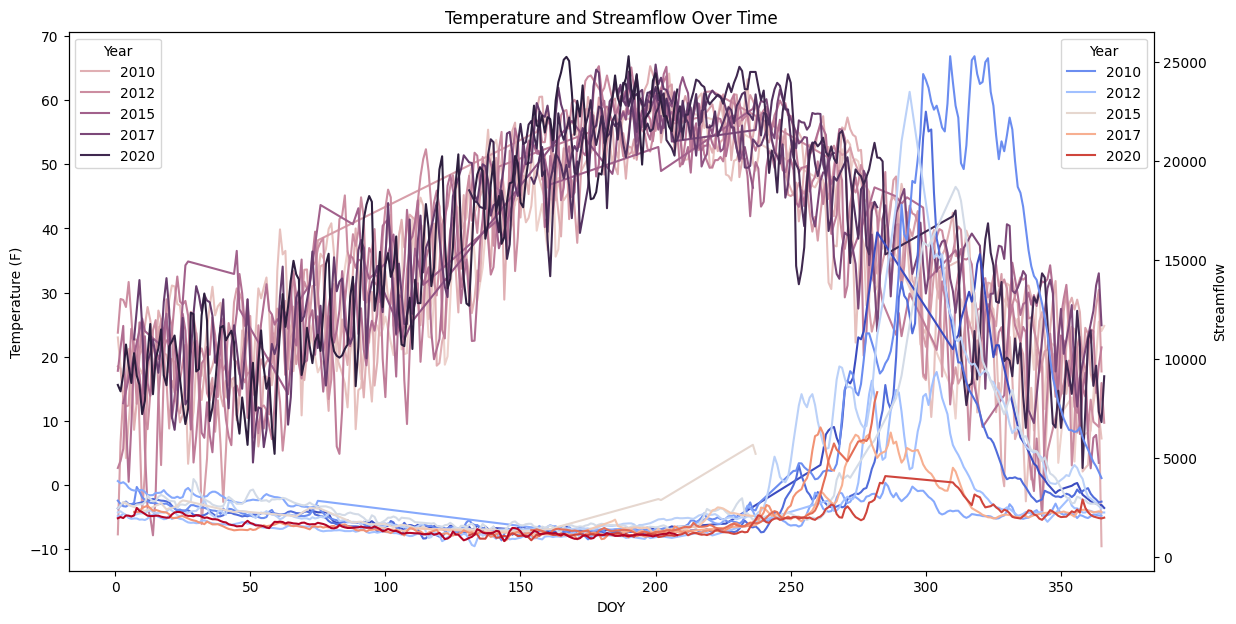

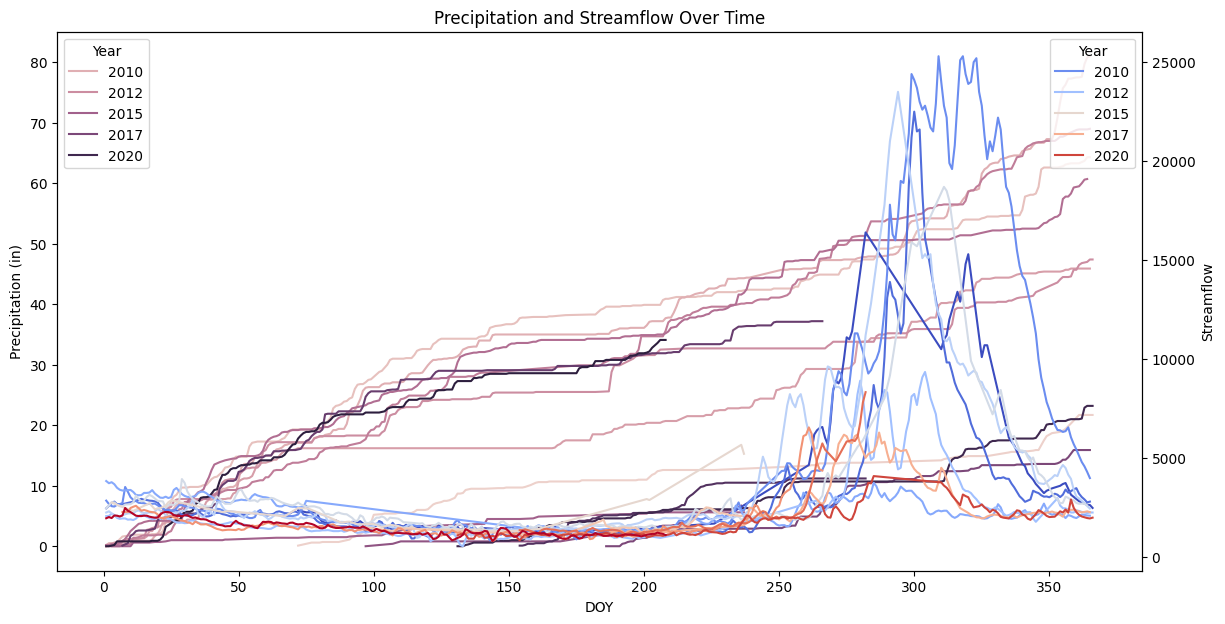

In [37]:
def plot_temp_streamflow(df):
    # plot temperature and streamflow by DOY
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # plot temperature
    sns.lineplot(data=df, x='DOY', y='TAVG', hue='year', ax=ax1)
    ax1.set_ylabel('Temperature (F)')
    ax1.set_title('Temperature and Streamflow Over Time')
    ax1.legend(title='Year', loc='upper left')

    # create a second y-axis for streamflow
    ax2 = ax1.twinx()
    sns.lineplot(data=df, x='DOY', y='streamflow', hue='year', ax=ax2, palette='coolwarm')
    ax2.set_ylabel('Streamflow')
    ax2.legend(title='Year', loc='upper right')

    plt.show()
    
def plot_prec_streamflow(df, prec_var='PRCP'):
   # plot precipitation and streamflow by DOY
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # plot precipitation
    sns.lineplot(data=df, x='DOY', y=prec_var, hue='year', ax=ax1)
    ax1.set_ylabel('Precipitation (in)')
    ax1.set_title('Precipitation and Streamflow Over Time')
    ax1.legend(title='Year', loc='upper left')

    # create a second y-axis for streamflow
    ax2 = ax1.twinx()
    sns.lineplot(data=df, x='DOY', y='streamflow', hue='year', ax=ax2, palette='coolwarm')
    ax2.set_ylabel('Streamflow')
    ax2.legend(title='Year', loc='upper right')

    plt.show()    

# Example usage:
plot_temp_streamflow(df)
plot_prec_streamflow(df, prec_var='PREC_year')

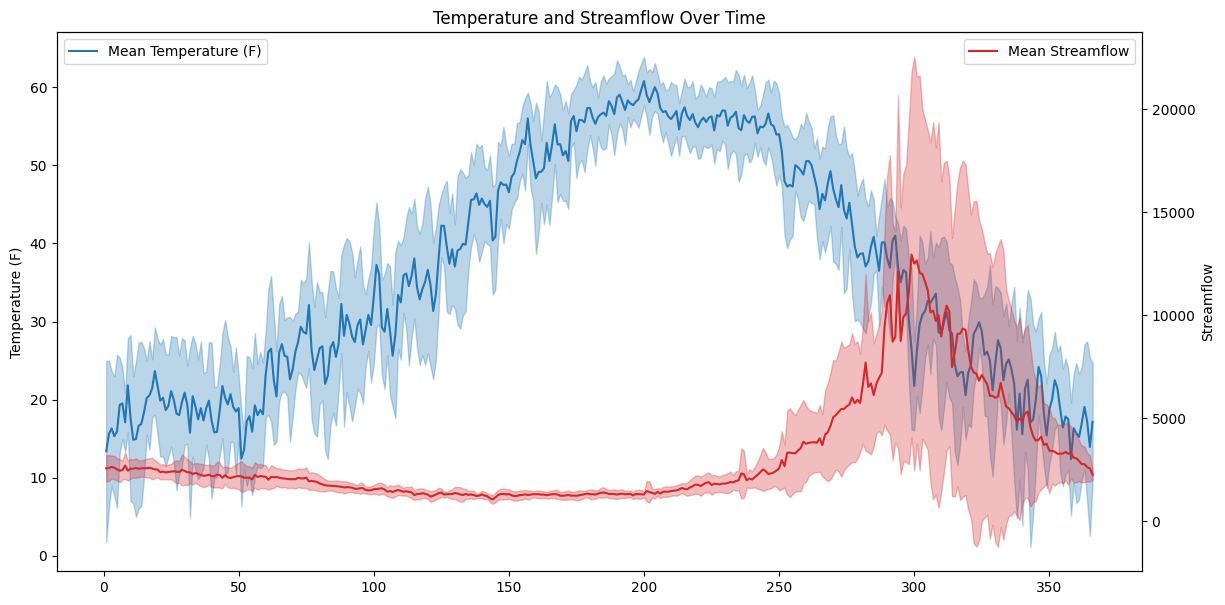

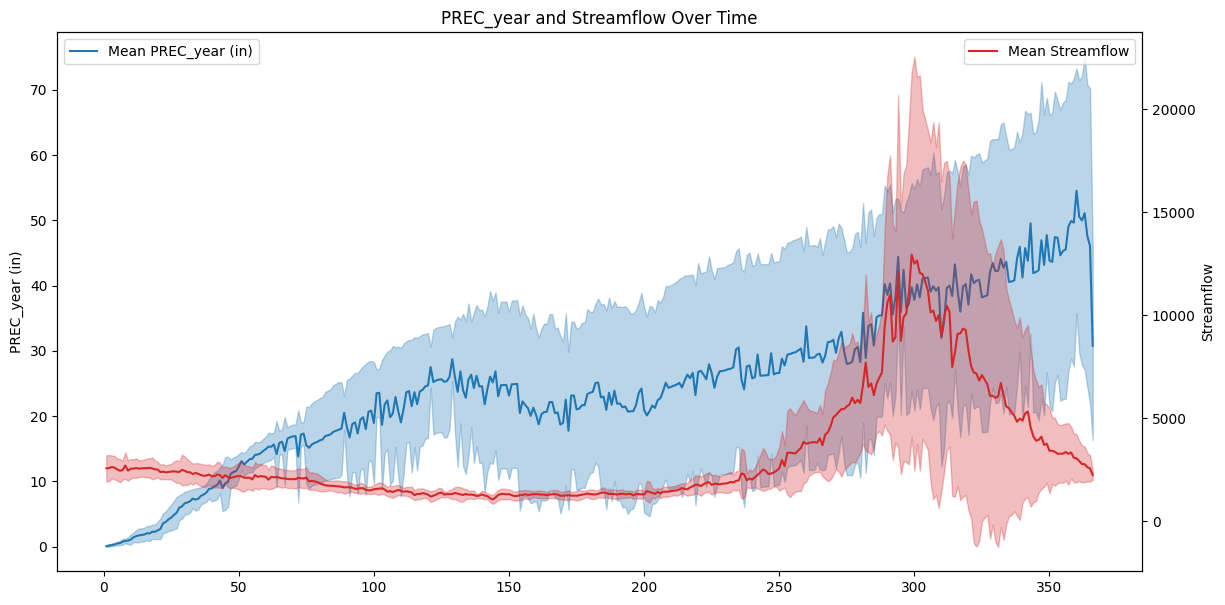

In [38]:
def plot_avg_temp_streamflow(df):
    # Calculate mean and standard deviation
    temp_mean = df.groupby('DOY')['TAVG'].mean()
    temp_std = df.groupby('DOY')['TAVG'].std()
    streamflow_mean = df.groupby('DOY')['streamflow'].mean()
    streamflow_std = df.groupby('DOY')['streamflow'].std()

    # Plot temperature and streamflow by DOY
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plot temperature
    ax1.plot(temp_mean.index, temp_mean, label='Mean Temperature (F)', color='tab:blue')
    ax1.fill_between(temp_mean.index, temp_mean - temp_std, temp_mean + temp_std, color='tab:blue', alpha=0.3)
    ax1.set_ylabel('Temperature (F)')
    ax1.set_title('Temperature and Streamflow Over Time')
    ax1.legend(loc='upper left')

    # Create a second y-axis for streamflow
    ax2 = ax1.twinx()
    ax2.plot(streamflow_mean.index, streamflow_mean, label='Mean Streamflow', color='tab:red')
    ax2.fill_between(streamflow_mean.index, streamflow_mean - streamflow_std, streamflow_mean + streamflow_std, color='tab:red', alpha=0.3)
    ax2.set_ylabel('Streamflow')
    ax2.legend(loc='upper right')

    plt.show()
    
def plot_avg_prec_streamflow(df, prec_var='PRCP'):
    # Calculate mean and standard deviation
    prec_mean = df.groupby('DOY')[prec_var].mean()
    prec_std = df.groupby('DOY')[prec_var].std()
    streamflow_mean = df.groupby('DOY')['streamflow'].mean()
    streamflow_std = df.groupby('DOY')['streamflow'].std()

    # Plot precipitation and streamflow by DOY
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plot precipitation
    ax1.plot(prec_mean.index, prec_mean, label=f'Mean {prec_var} (in)', color='tab:blue')
    ax1.fill_between(prec_mean.index, prec_mean - prec_std, prec_mean + prec_std, color='tab:blue', alpha=0.3)
    ax1.set_ylabel(f'{prec_var} (in)')
    ax1.set_title(f'{prec_var} and Streamflow Over Time')
    ax1.legend(loc='upper left')

    # Create a second y-axis for streamflow
    ax2 = ax1.twinx()
    ax2.plot(streamflow_mean.index, streamflow_mean, label='Mean Streamflow', color='tab:red')
    ax2.fill_between(streamflow_mean.index, streamflow_mean - streamflow_std, streamflow_mean + streamflow_std, color='tab:red', alpha=0.3)
    ax2.set_ylabel('Streamflow')
    ax2.legend(loc='upper right')

    plt.show()    

plot_avg_temp_streamflow(df)
plot_avg_prec_streamflow(df, prec_var='PREC_year')

# Add Features

In [39]:
df_model = df.copy()

def add_features(df_model):
    # df_model = df_model.asfreq('D').interpolate()
    
    # Add sine and cosine transformation of DOY
    df_model['sin_DOY'] = np.sin(2 * np.pi * df_model['DOY'] / 365)
    df_model['cos_DOY'] = np.cos(2 * np.pi * df_model['DOY'] / 365)

    # Add lagged streamflow values
    df_model['streamflow_lag1'] = df_model['streamflow'].shift(1)
    df_model['streamflow_lag2'] = df_model['streamflow'].shift(2)
    df_model['streamflow_lag3'] = df_model['streamflow'].shift(3)

    # Calculate rolling precipitation sums
    df_model['PRCP_weekly'] = df_model['PRCP'].rolling(window=7, min_periods=1).sum()
    df_model['PRCP_monthly'] = df_model['PRCP'].rolling(window=30, min_periods=1).sum()

    # rearrange
    df_model = df_model[['year', 'DOY', 'sin_DOY', 'cos_DOY', 'TAVG', 'PRCP', 
                         'PREC_year', 'PREC_month', 'PREC_week', 'PRCP_weekly', 
                         'PRCP_monthly', 'streamflow_lag1', 'streamflow_lag2', 
                         'streamflow_lag3', 'streamflow']]

    return df_model

df_model = add_features(df_model)
df_model = df_model.asfreq('D').dropna()
display(df_model)

# options to consider:
# - add features
# - remove incomplete years
# - interpolate missing values
# - interpolate missing values, then add features

,year,DOY,sin_DOY,cos_DOY,TAVG,PRCP,PREC_year,PREC_month,PREC_week,PRCP_weekly,PRCP_monthly,streamflow_lag1,streamflow_lag2,streamflow_lag3,streamflow
date,,,,,,,,,,,,,,,
2008-03-18,2008.0,78.0,0.974100,0.226116,17.85,0.0,0.6,45.3,9.7,0.6,0.6,2260.0,2260.0,2360.0,2260.0
2008-03-19,2008.0,79.0,0.977848,0.209315,25.50,0.0,0.6,45.3,9.7,0.6,0.6,2260.0,2260.0,2260.0,2200.0
2008-03-20,2008.0,80.0,0.981306,0.192452,26.60,0.0,0.6,45.3,9.7,0.6,0.6,2200.0,2260.0,2260.0,1930.0
2008-03-21,2008.0,81.0,0.984474,0.175531,24.00,0.1,0.7,45.3,9.7,0.7,0.7,1930.0,2200.0,2260.0,1780.0
2008-03-22,2008.0,82.0,0.987349,0.158559,17.75,0.0,0.7,45.3,9.7,0.6,0.7,1780.0,1930.0,2200.0,1740.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-23,2021.0,204.0,-0.361714,-0.932289,57.50,0.4,33.2,44.7,10.5,1.6,4.6,1170.0,1150.0,1120.0,1170.0
2021-07-24,2021.0,205.0,-0.377708,-0.925925,55.85,0.4,33.6,44.7,10.5,1.7,5.0,1170.0,1170.0,1150.0,1240.0
2021-07-25,2021.0,206.0,-0.393590,-0.919286,55.15,0.5,34.1,44.7,10.5,2.2,4.7,1240.0,1170.0,1170.0,1190.0


In [40]:
def train_test_split(df, test_size=0.2):
    # Calculate the index for the split
    split_index = int((1 - test_size) * len(df))

    # Split the data
    train = df.iloc[:split_index]
    test = df.iloc[split_index:]

    return train, test

train, test = train_test_split(df_model)
X_train, y_train = train.drop(columns='streamflow'), train['streamflow']
X_test, y_test = test.drop(columns='streamflow'), test['streamflow']

display(X_train, X_test)

# options to consider:
# - train/test split by date
# - train/test split by index

,year,DOY,sin_DOY,cos_DOY,TAVG,PRCP,PREC_year,PREC_month,PREC_week,PRCP_weekly,PRCP_monthly,streamflow_lag1,streamflow_lag2,streamflow_lag3
date,,,,,,,,,,,,,,
2008-03-18,2008.0,78.0,0.974100,0.226116,17.85,0.0,0.6,45.3,9.7,0.6,0.6,2260.0,2260.0,2360.0
2008-03-19,2008.0,79.0,0.977848,0.209315,25.50,0.0,0.6,45.3,9.7,0.6,0.6,2260.0,2260.0,2260.0
2008-03-20,2008.0,80.0,0.981306,0.192452,26.60,0.0,0.6,45.3,9.7,0.6,0.6,2200.0,2260.0,2260.0
2008-03-21,2008.0,81.0,0.984474,0.175531,24.00,0.1,0.7,45.3,9.7,0.7,0.7,1930.0,2200.0,2260.0
2008-03-22,2008.0,82.0,0.987349,0.158559,17.75,0.0,0.7,45.3,9.7,0.6,0.7,1780.0,1930.0,2200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-10,2018.0,191.0,-0.145799,-0.989314,59.80,0.1,30.1,44.7,7.6,0.2,1.0,1000.0,1050.0,1160.0
2018-07-11,2018.0,192.0,-0.162807,-0.986658,57.35,0.7,30.8,44.7,7.6,0.9,1.7,1110.0,1000.0,1050.0
2018-07-12,2018.0,193.0,-0.179767,-0.983709,55.05,0.3,31.1,44.7,7.6,1.2,2.0,1070.0,1110.0,1000.0


,year,DOY,sin_DOY,cos_DOY,TAVG,PRCP,PREC_year,PREC_month,PREC_week,PRCP_weekly,PRCP_monthly,streamflow_lag1,streamflow_lag2,streamflow_lag3
date,,,,,,,,,,,,,,
2018-07-15,2018.0,196.0,-0.230306,-0.973118,56.20,0.4,31.5,44.7,7.6,1.5,2.4,1090.0,1100.0,1050.0
2018-07-16,2018.0,197.0,-0.247022,-0.969010,59.95,0.0,31.5,44.7,10.5,1.5,2.4,1030.0,1090.0,1100.0
2018-07-17,2018.0,198.0,-0.263665,-0.964614,59.60,0.1,31.6,44.7,10.5,1.5,2.5,1050.0,1030.0,1090.0
2018-07-18,2018.0,199.0,-0.280231,-0.959933,61.60,0.0,31.6,44.7,10.5,0.8,2.3,1070.0,1050.0,1030.0
2018-07-19,2018.0,200.0,-0.296713,-0.954967,65.55,0.1,31.7,44.7,10.5,0.6,1.9,1130.0,1070.0,1050.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-23,2021.0,204.0,-0.361714,-0.932289,57.50,0.4,33.2,44.7,10.5,1.6,4.6,1170.0,1150.0,1120.0
2021-07-24,2021.0,205.0,-0.377708,-0.925925,55.85,0.4,33.6,44.7,10.5,1.7,5.0,1170.0,1170.0,1150.0
2021-07-25,2021.0,206.0,-0.393590,-0.919286,55.15,0.5,34.1,44.7,10.5,2.2,4.7,1240.0,1170.0,1170.0


# SARIMAX

In [42]:
# sarimax modeling
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

def sarimax_model(X_train, y_train, X_test, y_test):
    # Fit a SARIMAX model
    model = SARIMAX(y_train, exog=X_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 365))
    # model = SARIMAX(y_train, exog=X_train, order=(1, 1, 1))
    model_fit = model.fit(disp=False)

    # Make predictions
    y_pred = model_fit.predict(start=len(X_train), end=len(X_train) + len(X_test) - 1, exog=X_test)

    # Calculate the RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return y_pred, rmse

y_pred, rmse = sarimax_model(X_train, y_train, X_test, y_test)
print(f'RMSE: {rmse}')

def plot_results(y_test, y_pred):
    # Plot the actual values
    plt.figure(figsize=(14, 7))
    plt.plot(y_test.index, y_test, label='Actual', color='tab:blue')

    # Plot the predicted values
    plt.plot(y_test.index, y_pred, label='Predicted', color='tab:red')

    plt.title('Streamflow SARIMAX Model')
    plt.ylabel('Streamflow')
    plt.legend()
    plt.show()
    
plot_results(y_test, y_pred)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarni

KeyboardInterrupt: 